## Import Dependencies

In [ ]:
# List of external libraries used:
# pandas: https://pandas.pydata.org
# numpy: https://numpy.org
# matplotlub: https://matplotlib.org
# sklearn: https://scikit-learn.org

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("drive/My Drive/Colab Notebooks/CMPT419Project/model")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from sklearn.utils import shuffle

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AvgPool2D, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2022-03-26 13:45:15.965483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hvtruong/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-26 13:45:15.965533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Preprocessing:

## Landmarks detection

In [2]:
import dlib

predictor = dlib.shape_predictor('../Dataset/utils/shape_predictor_68_face_landmarks.dat')

def get_landmarks(face):
    landmarks = predictor(face, dlib.rectangle(0,0,63,63))
    landmarks_image = np.zeros((64,64))
    for i in range(0, 68):
        cv2.circle(landmarks_image, (landmarks.part(i).x, landmarks.part(i).y), 1, 255, 1)
  
    return landmarks_image

## Load the dataset

In [3]:
import h5py

filename = "../Dataset/facial_data/facial_data.h5"

data = np.zeros((25844,64,64,2))

with h5py.File(filename, "r") as f:
    keys = list(f.keys())
    # Get the data
    for i in range(int(len(keys))):
      data[i,:,:,0] = (np.array(f[keys[i]]))
      data[i,:,:,1] = (get_landmarks(np.array(f[keys[i]])))

data = np.array(data)

df = pd.read_csv('../Dataset/src_data/label_data.csv')
df = df[df['file_name'].isin(keys)]
targets = df[['arousal', 'valence']].values

data, targets = shuffle(data, targets)

# Model

## Model take input as gray images

In [4]:
learning_rate = 0.0001
epochs = 30
batch_size = 64

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='../models/grayImagesModel.h5', monitor='val_loss', save_best_only=True)]

In [9]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

for train_index, val_index in kf.split(data):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(64,64,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 32x32x16

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 16x16x32

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2, activation='linear'))

    model.compile(loss = 'mse', optimizer = Adam(learning_rate))

    x_train = data[train_index][:,:,:,0]
    y_train = targets[train_index]
    x_val = data[val_index][:,:,:,0]
    y_val = targets[val_index]

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callbacks], verbose=1, validation_data= (x_val, y_val))

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

Epoch 1/30
  3/324 [..............................] - ETA: 3:12 - loss: 9.6046

KeyboardInterrupt: 

In [ ]:
print(np.mean(loss))
print(np.mean(val_loss))

In [ ]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [ ]:
y_pred = model.predict(x_val)
for rand_num in np.random.randint(0, len(y_val), 10):
    plt.figure()
    plt.imshow(x_val[rand_num].reshape(48, 48),cmap='gray')
    plt.axis('off')
    plt.title('Prediction: ' + str(y_pred[rand_num]) + ' Real: ' + str(y_val[rand_num]), color='g')

## Model takes inputs as gray images with an addtional landmarks layer

In [7]:
learning_rate = 0.0001
epochs = 30
batch_size = 64

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='../models/2layersInputModel_max.h5', monitor='val_loss', save_best_only=True)]

In [8]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

for train_index, val_index in kf.split(data):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(64,64,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 128x128x16

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 64x64x32

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2, activation='linear'))

    model.compile(loss = 'mse', optimizer = Adam(learning_rate))

    x_train = data[train_index]
    y_train = targets[train_index]
    x_val = data[val_index]
    y_val = targets[val_index]

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callbacks], verbose=1, validation_data= (x_val, y_val))

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

2022-03-25 17:02:26.758769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hvtruong/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-25 17:02:26.758826: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-25 17:02:26.758850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Viete): /proc/driver/nvidia/version does not exist
2022-03-25 17:02:26.759179: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 17:02:27.838868: W te

Epoch 1/30
324/324 [==============================] - 189s 580ms/step - loss: 7.2752 - val_loss: 6.6888
Epoch 2/30
324/324 [==============================] - 144s 445ms/step - loss: 6.3234 - val_loss: 5.4736
Epoch 3/30
324/324 [==============================] - 127s 393ms/step - loss: 5.4880 - val_loss: 4.5677
Epoch 4/30
324/324 [==============================] - 152s 469ms/step - loss: 4.7094 - val_loss: 4.2227
Epoch 5/30
324/324 [==============================] - 142s 439ms/step - loss: 4.1884 - val_loss: 4.1393
Epoch 6/30
324/324 [==============================] - 130s 400ms/step - loss: 3.7798 - val_loss: 3.7576
Epoch 7/30
324/324 [==============================] - 153s 473ms/step - loss: 3.4699 - val_loss: 3.7024
Epoch 8/30
324/324 [==============================] - 139s 428ms/step - loss: 3.2285 - val_loss: 3.2966
Epoch 9/30
324/324 [==============================] - 139s 430ms/step - loss: 3.0251 - val_loss: 3.0453
Epoch 10/30
324/324 [==============================] - 138s 427m

2022-03-25 17:53:26.896002: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 677478400 exceeds 10% of free system memory.


Epoch 1/30
324/324 [==============================] - 123s 377ms/step - loss: 7.4231 - val_loss: 6.9696
Epoch 2/30
324/324 [==============================] - 119s 366ms/step - loss: 6.7004 - val_loss: 5.9824
Epoch 3/30
324/324 [==============================] - 118s 363ms/step - loss: 6.0784 - val_loss: 5.1919
Epoch 4/30
324/324 [==============================] - 119s 366ms/step - loss: 5.3635 - val_loss: 4.5915
Epoch 5/30
324/324 [==============================] - 119s 367ms/step - loss: 4.7352 - val_loss: 3.9807
Epoch 6/30
324/324 [==============================] - 119s 366ms/step - loss: 4.1754 - val_loss: 3.8398
Epoch 7/30
324/324 [==============================] - 118s 364ms/step - loss: 3.8684 - val_loss: 3.4949
Epoch 8/30
324/324 [==============================] - 118s 365ms/step - loss: 3.5384 - val_loss: 3.1902
Epoch 9/30
324/324 [==============================] - 118s 365ms/step - loss: 3.3215 - val_loss: 3.0921
Epoch 10/30
324/324 [==============================] - 118s 365m

2022-03-25 18:52:36.724968: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 677478400 exceeds 10% of free system memory.


Epoch 1/30
324/324 [==============================] - 120s 368ms/step - loss: 7.2661 - val_loss: 6.7578
Epoch 2/30
324/324 [==============================] - 118s 364ms/step - loss: 6.4694 - val_loss: 5.7161
Epoch 3/30
324/324 [==============================] - 118s 364ms/step - loss: 5.7291 - val_loss: 4.8048
Epoch 4/30
324/324 [==============================] - 118s 365ms/step - loss: 4.9955 - val_loss: 4.2804
Epoch 5/30
324/324 [==============================] - 118s 364ms/step - loss: 4.3690 - val_loss: 3.9816
Epoch 6/30
324/324 [==============================] - 118s 364ms/step - loss: 3.9782 - val_loss: 3.6558
Epoch 7/30
324/324 [==============================] - 118s 364ms/step - loss: 3.6125 - val_loss: 3.5783
Epoch 8/30
324/324 [==============================] - 118s 365ms/step - loss: 3.3364 - val_loss: 3.2209
Epoch 9/30
324/324 [==============================] - 119s 366ms/step - loss: 3.0917 - val_loss: 2.8938
Epoch 10/30
324/324 [==============================] - 118s 363m

2022-03-25 19:52:01.089912: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 677478400 exceeds 10% of free system memory.


Epoch 1/30
324/324 [==============================] - 123s 377ms/step - loss: 7.3881 - val_loss: 7.1187
Epoch 2/30
324/324 [==============================] - 122s 377ms/step - loss: 6.6514 - val_loss: 5.9731
Epoch 3/30
324/324 [==============================] - 122s 377ms/step - loss: 5.9654 - val_loss: 5.1520
Epoch 4/30
324/324 [==============================] - 122s 376ms/step - loss: 5.2465 - val_loss: 4.4295
Epoch 5/30
324/324 [==============================] - 122s 376ms/step - loss: 4.6598 - val_loss: 4.0395
Epoch 6/30
324/324 [==============================] - 121s 374ms/step - loss: 4.1839 - val_loss: 3.5428
Epoch 7/30
324/324 [==============================] - 122s 377ms/step - loss: 3.8112 - val_loss: 3.3972
Epoch 8/30
324/324 [==============================] - 122s 378ms/step - loss: 3.5392 - val_loss: 3.0820
Epoch 9/30
324/324 [==============================] - 123s 380ms/step - loss: 3.2775 - val_loss: 2.8305
Epoch 10/30
324/324 [==============================] - 122s 376m

2022-03-25 20:53:18.058645: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 677511168 exceeds 10% of free system memory.


Epoch 1/30
324/324 [==============================] - 122s 374ms/step - loss: 7.4329 - val_loss: 6.8953
Epoch 2/30
324/324 [==============================] - 120s 370ms/step - loss: 6.6055 - val_loss: 5.7711
Epoch 3/30
324/324 [==============================] - 120s 370ms/step - loss: 5.8380 - val_loss: 4.9757
Epoch 4/30
324/324 [==============================] - 121s 372ms/step - loss: 5.1354 - val_loss: 4.3881
Epoch 5/30
324/324 [==============================] - 121s 373ms/step - loss: 4.5287 - val_loss: 4.0356
Epoch 6/30
324/324 [==============================] - 121s 372ms/step - loss: 4.0751 - val_loss: 3.7621
Epoch 7/30
324/324 [==============================] - 121s 373ms/step - loss: 3.7236 - val_loss: 3.2632
Epoch 8/30
324/324 [==============================] - 121s 374ms/step - loss: 3.4419 - val_loss: 3.1916
Epoch 9/30
324/324 [==============================] - 121s 374ms/step - loss: 3.1591 - val_loss: 3.2153
Epoch 10/30
324/324 [==============================] - 121s 372m

In [9]:
print(np.mean(loss))
print(np.mean(val_loss))

1.5380261659622192
2.0109084606170655


In [ ]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [ ]:
y_pred = model.predict(x_val)
for rand_num in np.random.randint(0, len(y_val), 10):
    plt.figure()
    plt.imshow(x_val[rand_num].reshape(48, 48),cmap='gray')
    plt.axis('off')
    plt.title('Prediction: ' + str(y_pred[rand_num]) + ' Real: ' + str(y_val[rand_num]), color='g')

## Model takes inputs as gray images with landmarks concatenated at latent space

In [4]:
learning_rate = 0.001
epochs = 30
batch_size = 64

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='../models/landmarksConcatenatedModel.h5', monitor='val_loss', save_best_only=True)]

In [5]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

for train_index, val_index in kf.split(data):

    img_input = Input((64,64,1))
    landmarks_input = Input((64*64))

    cnnLayers = Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(64,64,1), padding='same')(img_input)
    cnnLayers = BatchNormalization()(cnnLayers)
    cnnLayers = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
    cnnLayers = BatchNormalization()(cnnLayers)

    cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
    cnnLayers = Dropout(0.25)(cnnLayers)

    #model.add(MaxPool2D(strides=(2,2)))
    #Output dimension: 128x128x16

    cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
    cnnLayers = BatchNormalization()(cnnLayers)
    cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
    cnnLayers = BatchNormalization()(cnnLayers)

    cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
    cnnLayers = Dropout(0.25)(cnnLayers)

    cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
    cnnLayers = Dropout(0.25)(cnnLayers)

    #model.add(MaxPool2D(strides=(2,2)))
    #Output dimension: 64x64x32

    flatten_layer = Flatten()(cnnLayers)
    
    concatenate_layer = concatenate([flatten_layer, landmarks_input])
    dense = Dense(512, activation='relu')(concatenate_layer)
    dense = Dropout(0.25)(dense)

    dense = Dense(1024, activation='relu')(dense)
    dense = Dropout(0.4)(dense)

    output = Dense(2, activation='linear')(dense)

    model = Model(inputs=[img_input, landmarks_input], outputs=output)
    model.compile(loss = 'mse', optimizer = Adam(learning_rate))

    x_train = data[train_index]
    y_train = targets[train_index]
    x_val = data[val_index]
    y_val = targets[val_index]

    history = model.fit(x=[x_train[:,:,:,0], np.reshape(x_train[:,:,:,1],((x_train.shape[0],64*64)))], y=y_train, epochs=epochs, batch_size=batch_size, callbacks=[callbacks], verbose=1, validation_data= ([x_val[:,:,:,0], np.reshape(x_val[:,:,:,1],((x_val.shape[0],64*64)))], y_val))

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

2022-03-24 17:19:54.518036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hvtruong/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-24 17:19:54.518120: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-24 17:19:54.518151: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Viete): /proc/driver/nvidia/version does not exist
2022-03-24 17:19:54.518792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
324/324 [==============================] - 177s 543ms/step - loss: 244.3669 - val_loss: 7.7922
Epoch 2/30
324/324 [==============================] - 175s 541ms/step - loss: 8.6216 - val_loss: 6.9578
Epoch 3/30
324/324 [==============================] - 175s 539ms/step - loss: 8.2960 - val_loss: 6.9155
Epoch 4/30
324/324 [==============================] - 175s 539ms/step - loss: 7.8737 - val_loss: 6.8936
Epoch 5/30
324/324 [==============================] - 166s 513ms/step - loss: 7.6889 - val_loss: 6.8653
Epoch 6/30
324/324 [==============================] - 136s 419ms/step - loss: 9.2975 - val_loss: 6.8719
Epoch 7/30
324/324 [==============================] - 137s 423ms/step - loss: 8.1785 - val_loss: 6.8568
Epoch 8/30
324/324 [==============================] - 141s 435ms/step - loss: 9.1855 - val_loss: 6.8221
Epoch 9/30
324/324 [==============================] - 138s 425ms/step - loss: 7.2914 - val_loss: 6.8967
Epoch 10/30
324/324 [==============================] - 138s 42

9.363943958282471
7.113777732849121


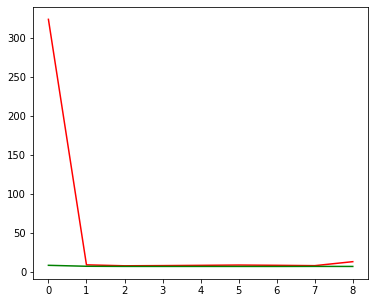

In [6]:
print(np.mean(loss))
print(np.mean(val_loss))

plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [ ]:
y_pred = model.predict(x_val)
for rand_num in np.random.randint(0, len(y_val), 10):
    plt.figure()
    plt.imshow(x_val[rand_num].reshape(48, 48),cmap='gray')
    plt.axis('off')
    plt.title('Prediction: ' + str(y_pred[rand_num]) + ' Real: ' + str(y_val[rand_num]), color='g')